In [1]:
import pandas as pd
import numpy as np
pd.options.display.max_columns=1000

In [2]:
from featurewiz import LazyTransformer, SuloRegressor, SuloClassifier
from featurewiz import FeatureWiz, cross_val_model_predictions, get_class_weights
from featurewiz import print_regression_metrics, print_classification_metrics,print_sulo_accuracy

Imported lazytransform v1.11. 

Imported featurewiz 0.5.2. Use the following syntax:
    >>> wiz = FeatureWiz(feature_engg = '', nrows=None, transform_target=True, scalers="std",
        		category_encoders="auto", add_missing=False, verbose=0. imbalanced=False,
        		ae_options={})
    >>> X_train_selected, y_train = wiz.fit_transform(X_train, y_train)
    >>> X_test_selected = wiz.transform(X_test)
    >>> selected_features = wiz.features
    


In [3]:
trainfile = 'c:/users/ram/documents/ram/data_sets/kaggle/diabetes.csv'
datapath = '../Ram/Data_Sets/'
filename = 'winequality.csv'
filename = 'affairs.csv'
trainfile = datapath+filename
sep = ','
dft = pd.read_csv(trainfile,sep=sep)
dft.drop(['affair', 'affairs'],axis=1, inplace=True)
print(dft.shape)
dft.head()

(6366, 9)


,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affair_multiclass
0,3.0,32.0,9.0,3.0,3.0,17.0,2.0,5.0,0
1,3.0,27.0,13.0,3.0,1.0,14.0,3.0,4.0,3
2,4.0,22.0,2.5,0.0,1.0,16.0,3.0,5.0,1
3,4.0,37.0,16.5,4.0,3.0,16.0,5.0,5.0,0
4,5.0,27.0,9.0,1.0,1.0,14.0,3.0,4.0,4


In [4]:
target = 'affair_multiclass'
modeltype = 'Multi_Classification'
preds = [x for x in list(dft) if x not in target]
dft[target].nunique()

7

In [5]:
from featurewiz import StackingClassifier_Multi, get_class_distribution

In [6]:
from sklearn.model_selection import train_test_split
from featurewiz import FE_kmeans_resampler
if modeltype == 'Regression':
    X_train, X_test, y_train, y_test = train_test_split(dft[preds], dft[target], test_size=0.20, random_state=1,)
    X_train_over, y_train_over = FE_kmeans_resampler(X_train, y_train, target, smote='',verbose=0)
    print(X_train_over.shape, X_test.shape)
    #train, test = pd.concat([X_train_over, pd.Series(y_train_over,name=target)], axis=1), pd.concat([X_test, y_test], axis=1)
    train, test = train_test_split(dft, test_size=0.20, random_state=42)
else:
    X_train, X_test, y_train, y_test = train_test_split(dft[preds], dft[target], test_size=0.20, 
                                                    stratify=dft[target],
                                                    random_state=42)
    train, test = train_test_split(dft, test_size=0.20, random_state=42,
                                                    stratify=dft[target]
                                                   )
print(X_train.shape, X_test.shape)

(5092, 8) (1274, 8)


In [7]:
transform_target = True

featurewiz is given 0.8 as correlation limit...
    final list of feature engineering given: ['dae_add']
    final list of category encoders given: ['onehot', 'label']
Since Auto Encoders are selected for feature extraction,
    Recursive XGBoost is skipped...
DenoisingAutoEncoder()
    AE dictionary given: dict_items([])
    final list of scalers given: [minmax]
Loaded input data. Shape = (5092, 8)
Performing hyper param selection for DAE. Will take approx. 81 seconds
    defining a pipeline with MinMaxScaler and DAE
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Epoch 1/3
255/255 [==============================] - 3s 5ms/step - loss: 0.4304 - mse: 0.4304 - val_loss: 0.0897 - val_mse: 0.0897
Epoch 2/3
255/255 [==============================] - 1s 4ms/step - loss: 0.1744 - mse: 0.1744 - val_loss: 0.0766 - val_mse: 0.0766
Epoch 3/3
255/255 [==============================] - 1s 4ms/step - loss: 0.1194 - mse: 0.1194 - val_loss: 0.0648 - val_mse: 0.0648
    time taken for DAE 

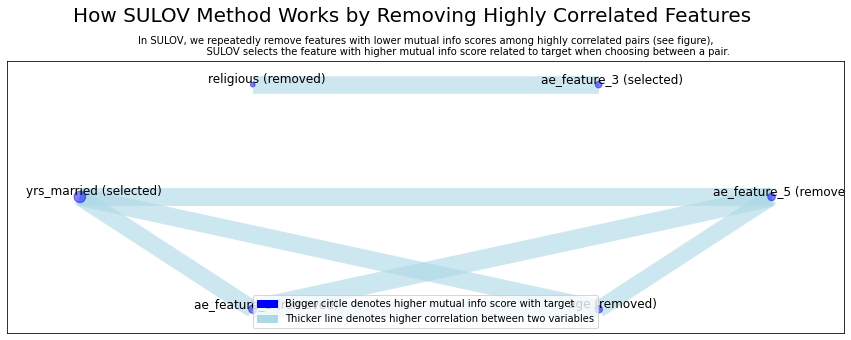

    time taken to run entire featurewiz = 45 second(s)
Recursive XGBoost selected 9 features...


In [8]:
fwiz = FeatureWiz(corr_limit=0.80, feature_engg='dae_add', category_encoders='auto', scalers='MinMax',
                 dask_xgboost_flag=False, nrows=None, verbose=2, skip_sulov=False,
                 skip_xgboost=False, transform_target=transform_target,
                 ae_options={}) 
X_train_selected, y_train = fwiz.fit_transform(X_train, y_train) 

In [9]:
X_test_selected = fwiz.transform(X_test) 

#### Starting featurewiz transform for test data ####
Loaded input data. Shape = (1274, 8)
    Beware! feature_engg will add 100s, if not 1000s of additional features to your dataset!
#### Starting lazytransform for test data ####
    Time taken to transform dataset = 1 second(s)
    Shape of transformed dataset: (1274, 8)
Shape of transformed data due to auto encoder = (1274, 13)
Returning dataframe with 9 features 


In [10]:
if transform_target:
    y_test = fwiz.lazy.yformer.transform(y_test)

In [11]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, classification_report

# Updating the Random Forest Classifier with the corrected class weights
if modeltype == 'Regression':
    rf_classifier = RandomForestRegressor(random_state=42)
else:
    # Correctly computing class weights for the classes present in the training set
    class_weights_dict_corrected = get_class_distribution(y_train)
    rf_classifier = RandomForestClassifier(class_weight=class_weights_dict_corrected, random_state=42)


# Fitting the classifier on the training data
rf_classifier.fit(X_train_selected, y_train)

# Predicting on the test set
y_pred = rf_classifier.predict(X_test_selected)

if modeltype == 'Regression':
    print_regression_metrics(y_test, y_pred, verbose=1)
else:
    # Evaluating the classifier
    y_probas = rf_classifier.predict_proba(X_test_selected)
    print_classification_metrics(y_test, y_pred, y_probas, verbose=1)

Bal accu 16%
ROC AUC = 0.71
              precision    recall  f1-score   support

           0       0.83      0.95      0.89      1050
           1       0.11      0.03      0.05        86
           2       0.13      0.04      0.06        48
           3       0.00      0.00      0.00        26
           4       0.17      0.06      0.09        35
           5       0.00      0.00      0.00        17
           6       0.00      0.00      0.00        12

    accuracy                           0.79      1274
   macro avg       0.18      0.16      0.16      1274
weighted avg       0.70      0.79      0.74      1274

final average balanced accuracy score = 0.16


In [12]:
print('Time taken = %0.0f seconds' %(time.time()-start_time))

NameError: name 'time' is not defined

In [ ]:
disto

In [ ]:
from nn_modeler import NN_Modeler

In [ ]:
from featurewiz.blagging import BlaggingClassifier

In [ ]:
from featurewiz.ml_models import IterativeClassifier, IterativeForwardClassifier, IterativeBackwardClassifier
from featurewiz import IterativeDoubleClassifier

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
es = EarlyStopping(monitor='val_f1_score', patience=20, restore_best_weights=True, mode='max')
lr = ReduceLROnPlateau(monitor='val_f1_score', factor=0.90, patience=10, min_lr=0.0001)
callbacks = [lr, es]

In [ ]:
# Example usage
# Create and train the classifier
import numpy as np
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, classification_report
import time
start_time = time.time()

# Updating the Random Forest Classifier with the corrected class weights
if modeltype == 'Regression':
    rf_classifier = RandomForestRegressor(random_state=42)
else:
    # Correctly computing class weights for the classes present in the training set
    class_weights_dict_corrected = get_class_weights(y_train)
    ### The Double Classifier is best of the bunch!  It provides very high ROC_AUC but low bal_accuracy
    #rf_classifier = IterativeDoubleClassifier( weights = {1: 0.5, 2: 0.5} )
    ### The Iterative Classifier is somewhat worse than a regular classifier. Don't know why.
    #rf_classifier = IterativeClassifier( threshold=100)
    rf_classifier = NN_Modeler(activation='selu', learning_rate=0.001, batch_size=32,
                               num_hidden_layers=3,
                               epochs=500, callbacks=callbacks)


# Fitting the classifier on the training data
rf_classifier.fit(X_train_selected, y_train)

# Predicting on the test set
y_pred = rf_classifier.predict(X_test_selected)

if modeltype == 'Regression':
    print_regression_metrics(y_test, y_pred, verbose=1)
else:
    # Evaluating the classifier
    y_probas = rf_classifier.predict_proba(X_test_selected)
    print_classification_metrics(y_test, y_pred, y_probas, verbose=1)
print('Time taken = %0.0f seconds' %(time.time()-start_time))

In [ ]:
rf_classifier.batch_size